In [1]:
import numpy as np
import time
from scipy.optimize import differential_evolution, minimize, dual_annealing
import matplotlib.pyplot as plt
import concurrent.futures
import threading

import sys 
sys.path.append("../")  
import minionpy as mpy

# Minimizing Basic Functions

In this section, we minimize basic functions such as Sphere, Rosenbrock, and Rastrigin. The search space is shifted to prevent algorithms from converging near the origin, as some algorithms tend to favor that region.


In [2]:
def sphere(x) : 
    x =np.asarray(x)-1
    return 100+np.sum(x**2)

def rosenbrock(x):
    x = np.asarray(x)-1.0
    return 100+np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def rastrigin(x):
    x = np.asarray(x)-1.0
    A = 10
    return 100+A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

#remember that in minion, objective function must be vectorized. Suppose you want to 
func = rosenbrock
def objective_function(X) : 
    """ 
    Here, X is a list of x, where x is an input vector. 
    """
    return [func(x) for x in X] 

#Now minimize the function using minion 
dimension = 5 #set dimension of the problem
maxevals = 10000 #number of function calls
x0 = [3.0]*dimension # initial guess

min = mpy.Minimizer(func=objective_function, x0=x0, bounds=[(-10, 10)]*dimension, algo="ARRDE", relTol=0.0, maxevals=10000, callback=None, seed=None, options=None)
result = min.optimize()
print("The minimum of the function is ", "\n\t x : ", result.x, "\n\t f(x) : ", result.fun)

The minimum of the function is  
	 x :  [1.9964565753454473, 1.993389388433042, 1.987324983617462, 1.9749341300451158, 1.9494263517187491] 
	 f(x) :  100.0010080208193


In [3]:
# You can also compare different algorithms 
dimension=10
maxevals = 10000
func = rosenbrock
x0 = [3.0]*dimension # initial guess

algoList = ["DE","LSHADE", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP", "ARRDE", "GWO_DE", "NelderMead"]
for algo in algoList : 
    result = mpy.Minimizer(func=objective_function, x0=x0, bounds=[(-10, 10)]*dimension, algo=algo, relTol=0.0, 
                           maxevals=maxevals, callback=None, seed=None, options={"population_size":0}).optimize()
    print("Algorithm : ", algo, "\t f(x) : ", result.fun)

#compare to algorithms implemented in scipy 
res_DE = differential_evolution(func, bounds=[(-10, 10)]*dimension, strategy="best1bin", popsize=5*dimension, 
                                maxiter=int(maxevals/(5*dimension)-1), polish=False )
print("Algorithm : ", "Scipy DE", "\t f(x) : ", res_DE.fun)


res_minimize = minimize(func, x0 = [5.0 for _ in range(dimension)], method="Nelder-Mead", options={"maxfev": maxevals} )
print("Algorithm : ", "Scipy Nelder-Mead", "\t f(x) : ", res_minimize.fun)

res_dual = dual_annealing(func, bounds=[(-10, 10)]*dimension, maxfun=maxevals)
print("Algorithm : ", "Scipy Dual Annealing", "\t f(x) : ", res_dual.fun)

Algorithm :  DE 	 f(x) :  111.58490685004381
Algorithm :  LSHADE 	 f(x) :  103.2356736946052
Algorithm :  JADE 	 f(x) :  103.49377705816464
Algorithm :  jSO 	 f(x) :  104.32470200347
Algorithm :  j2020 	 f(x) :  100.38216824506756
Algorithm :  LSRTDE 	 f(x) :  106.0262309702043
Algorithm :  NLSHADE_RSP 	 f(x) :  105.2111287093586
Algorithm :  ARRDE 	 f(x) :  103.1889509717188
Algorithm :  GWO_DE 	 f(x) :  109.61479317522863
Algorithm :  NelderMead 	 f(x) :  100.00000000000003
Algorithm :  Scipy DE 	 f(x) :  104.6959999891185
Algorithm :  Scipy Nelder-Mead 	 f(x) :  103.9865791264969
Algorithm :  Scipy Dual Annealing 	 f(x) :  100.00000001041874


# Minimizing Expensive Functions with Multithreading/Multiprocessing

When the objective function is expensive to evaluate, multithreading can be used to speed up the calculation of the vectorized objective function. However, this requires that the objective function is **thread-safe**. 

If the objective function is not thread-safe, then **multiprocessing** can be used instead. This approach allows parallel execution across separate processes, which avoids the potential issues with thread safety.


In [4]:
# Suppose the function to minimize is expensive to evaluate. In this case, multithreading helps. 
def func(x) : 
    ret = rastrigin(x)
    time.sleep(0.01) #each evaluation will take 0.01s now. 
    return ret

#Batch calculation of the function above is calculated using threadpoolexecutor with the number of threads equal to Nthreads
Nthreads = 8
executor = concurrent.futures.ThreadPoolExecutor(max_workers=Nthreads) #executor for multithreading
#executor = concurrent.futures.ProcessPoolExecutor(max_workers=Nthreads) #executor for multiprocessing
def objective_function(X) : 
    ret = list(executor.map(func, X))
    return ret

#Now minimize the function using minion 
dimension = 5 #set dimension of the problem
maxevals = 1500 #number of function calls
x0 = [3.0]*dimension # initial guess

now = time.time()
algo = "ARRDE"
min = mpy.Minimizer(func=objective_function, x0=x0, bounds=[(-10, 10)]*dimension, algo=algo, relTol=0.0, maxevals=maxevals, callback=None, seed=None, options=None)
result = min.optimize()
elapsed= time.time()-now
print("Algo : ",algo, "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")

#compared to scipy dual annealing that does not support multithreading natively
now = time.time()
res_dual = dual_annealing(func, bounds=[(-10, 10)]*dimension, maxfun=maxevals)
elapsed = time.time()-now
print("Algo : Scipy Dual Annealing ", "\n\t x : ", res_dual.x, "\n\t f(x) : ", res_dual.fun, "\n\t Elapsed: ", elapsed, " seconds")

#do not forget to shut down the executor
executor.shutdown()


Algo :  ARRDE 
	 x :  [1.988819673828297, 1.9986429348145451, 1.994789239140169, 1.996211112094925, 1.000468240793943] 
	 f(x) :  103.99035777074842 
	 Elapsed:  2.743412971496582  seconds

Algo : Scipy Dual Annealing  
	 x :  [1.         1.         0.00504136 0.00504136 0.99999999] 
	 f(x) :  101.98991811418661 
	 Elapsed:  15.482880353927612  seconds


# Algorithm Comparisons Using CEC Benchmark Problems

We can compare the performance of different optimization algorithms by evaluating them on benchmark problems from the Congress on Evolutionary Computation (CEC) competition. The Minion library provides implementations of benchmark problems from the following CEC years: 2011, 2014, 2017, 2019, 2020, and 2022.

- **CEC2014 and CEC2017**: These benchmarks contain 30 problems, implemented for dimensions 10, 20, 30, 50, and 100.
- **CEC2019**: This set includes 10 problems with varying dimensions.
- **CEC2020**: It contains 10 problems with dimensions 5, 10, 15, and 20.
- **CEC2022**: This set consists of 12 problems with dimensions 10 and 20.

CEC problems typically include a variety of function types:
- **Basic functions** (e.g., Rosenbrock, Rastrigin),
- **Hybrid functions** (new functions constructed by combining basic functions, where each component is evaluated using a different basic function),
- **Composite functions** (linear combinations of basic functions, where the coefficients are also functions of the input vector).

These functions are often shifted and rotated to introduce additional complexity.

CEC2011 consists of a set of real-world problems, idealized and simplified for the competition. It contains 22 problems of varying dimensions. Note that, for CEC2011, MATLAB must be installed on the system. An example of how to minimize CEC2011 problems can be found in `examples/cec_11.py`.


In [5]:
#this cell will minimize CEC benchmark problems and repeated for Nruns times. 
# Global results variable
results = []
results_lock = threading.Lock()

def test_optimization(func, bounds, dimension, func_name, Nmaxeval, seed):
    global results
    result = {}
    result['Dimensions'] = dimension
    result['Function'] = func_name
    bounds_list = [bounds] * dimension
    x0 = [0.0 for _ in range(dimension)]

    for algo in algos :
        res = mpy.Minimizer (func, bounds_list, x0=None, relTol=0.0,  algo=algo, maxevals=Nmaxeval, 
                             callback=None, seed=seed, options={"population_size": 0}).optimize()
        result[algo] = res.fun

    def func_scipy (par) : 
        return func([par])[0]
    
    dual_ann = dual_annealing(func_scipy, bounds_list, maxfun=Nmaxeval)
    result["Scipy dual annealing"] = dual_ann.fun

    with results_lock:
        results.append(result)
    print(result)

def run_test_optimization(j, dim, year=2017, seed=None):
    if year== 2014 : cec_func = mpy.CEC2014Functions(function_number=j, dimension=dim)
    elif year== 2017 : cec_func = mpy.CEC2017Functions(function_number=j, dimension=dim)
    elif year== 2019 : cec_func = mpy.CEC2019Functions(function_number=j)
    elif year== 2020 : cec_func = mpy.CEC2020Functions(function_number=j, dimension=dim)
    elif year== 2022 : cec_func = mpy.CEC2022Functions(function_number=j, dimension=dim)
    else : raise Exception("Unknown CEC year.")
    test_optimization(cec_func, (-100, 100), dim, "func_" + str(j), Nmaxeval, seed)


#algos = ["LSHADE", "NLSHADE_RSP", "j2020", "jSO", "LSRTDE", "GWO_DE", "DE", "JADE", "ARRDE"]
algos = ["LSRTDE", "ARRDE", "LSHADE"]

Nmaxeval = 10000 #maximum number of function calls
dimension = 10
NRuns= 1 #number of repeats
year = 2017  #cec year

func_numbers_dict = {
    2022 :  [1,2,3,4,5,6,7, 8, 9,10, 11, 12] , 
    2020 : [1,2,3,4,5,6,7, 8, 9,10], 
    2019 : [1,2,3,4,5,6,7, 8, 9,10], 
    2017 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], 
    2014 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
}
func_numbers= func_numbers_dict[year]


with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    futures = []
    for k in range(NRuns):
        for j in func_numbers:
            futures.append(executor.submit(run_test_optimization, j, dimension, year, k))
    concurrent.futures.wait(futures)
    for f in futures: f.result()

#report best, average, and std of the optimization results. 
for num in func_numbers : 
    mydict= {}
    algoRes = {algo : [] for algo in algos}
    for res in list(results) : 
        for algo in algoRes.keys() : 
            if res['Function'] == "func_"+str(num) :
                algoRes[algo].append(res[algo])

    full_results= {}
    for key, val in algoRes.items() : 
        full_results[key] = (np.min(val), np.mean(val), np.std(val)) #best, average, std
    print("Full results for function "+str(num) +":\n\t", full_results)


{'Dimensions': 10, 'Function': 'func_1', 'LSRTDE': 100.26303970862116, 'ARRDE': 100.01434778409082, 'LSHADE': 204.95416280853496, 'Scipy dual annealing': 100.00000317451402}
{'Dimensions': 10, 'Function': 'func_2', 'LSRTDE': 200.00000000100323, 'ARRDE': 200.00018388968857, 'LSHADE': 200.00008799350962, 'Scipy dual annealing': 200.00003821542072}
{'Dimensions': 10, 'Function': 'func_3', 'LSRTDE': 300.0000014575673, 'ARRDE': 300.0053614234508, 'LSHADE': 318.66727342820303, 'Scipy dual annealing': 300.0000000255791}
{'Dimensions': 10, 'Function': 'func_4', 'LSRTDE': 404.19685362367403, 'ARRDE': 400.4872808460072, 'LSHADE': 401.27932383106696, 'Scipy dual annealing': 400.0000000499494}
{'Dimensions': 10, 'Function': 'func_5', 'LSRTDE': 538.9120732945689, 'ARRDE': 511.93949908699983, 'LSHADE': 506.71639057859016, 'Scipy dual annealing': 521.8890791048763}
{'Dimensions': 10, 'Function': 'func_6', 'LSRTDE': 600.0016138356385, 'ARRDE': 600.0174268674474, 'LSHADE': 600.0749679388805, 'Scipy dua

# Example of using minion/py in curve fitting problems


Here, an example of using minion to minimize an objective function related to a curve fitting problem is demonstrated. 
The idea is first to define the data generation model, generate the data, fit the model, and report the result. 

## Polynomial Fitting Problems
In this problem, we try fit a polynomial from a set of data. Specifically, a set of points ($\{(x_i, y_i) \mid i = 1, 2, \dots, N\}$) with $x \in [0, 1]$ is generated according to:
$$
    f(x, a) = \sum_{j=0}^{D-1} a_j x^j
$$
Given the coefficients $a_j$ that generate the data, the goal is to reproduce the data points by minimizing the objective function:
$$
    L = \frac{1}{N}\sum_{i=1}^N \left(y_i - f(x_i, a)\right)^2 
$$


ARRDE  :  4.344379296176898e-09
LSHADE  :  1.3769954355361605e-07
LSRTDE  :  2.9461624873296486e-10
Dual Annealing :  1.0215221609760433e-06


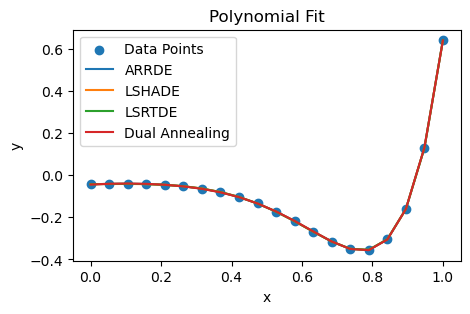

In [6]:
dimension=10 #the number of free parameters. The polynomial degree is just dimension-1
# Step 1: Generate data points from a polynomial 
np.random.seed(8)  # For reproducibility
# True coefficients of the polynomial (degree 10)
true_coefficients = [np.random.uniform(-1.0, 1.0)*1.0**i for i in range(dimension)]  # Random coefficients for the polynomial

# Generate dimension+10 data points
x_data = np.linspace(0.0, 1, dimension+10)
y_data = (np.polyval(true_coefficients, x_data))

# Step 2: Define the polynomial model
def polynomial_model(x, coefficients):
    """Given x and coefficients, return the polynomial value."""
    return (np.polyval(coefficients, x))

# Step 3: Define the objective function to minimize
def objective_function(coefficients):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = polynomial_model(x_data, coefficients)
    return np.mean((y_data - y_pred)**2)

def objective_function_vect(X) : 
    return [objective_function(x) for x in X ]


bounds= [(-10, 10)]*dimension
Nmaxeval= 10000
algos = ["ARRDE", "LSHADE", "LSRTDE" ]

# Step 4: Minimize the obj function and plot the results
plt.figure(figsize=(5,3))
plt.scatter(x_data, y_data, label='Data Points')

for algo in algos : 
    res = mpy.Minimizer(objective_function_vect, bounds, x0=None, relTol=0.0, algo = algo, maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
    print(algo , " : ", res.fun)
    plt.plot(x_data, polynomial_model(x_data, res.x ), label=algo)

dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval)
print("Dual Annealing : ", dual_ann.fun)
plt.plot(x_data, polynomial_model(x_data, dual_ann.x ), label="Dual Annealing")
plt.legend()
plt.title('Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Gaussian Mixture Model Fitting Problems

Thsi time, the model is given by the sum of Gaussian functions:
$$
    f(x, a, b, c) = \sum_{j=1}^{D/3} \frac{a_j}{\sum_{k=1}^{D/3} a_k} \frac{1}{b_j \sqrt{2\pi}} \exp\left[-\frac{1}{2} \frac{(x-c_j)^2}{b_j^2}\right]
$$
Here, $f(x, a, b, c)$ is normalized to represent a probability distribution. The data points are generated using predefined values of $a_j$, $b_j$, and $c_j$ within the interval $x \in [-20, 20]$. The objective function is the same as in the case of polynomial fitting. 


LSRTDE  :  0.0003953573119466844
LSHADE  :  0.0021591952181266656
ARRDE  :  6.445729384385046e-07
Dual Annealing :  5.848370567089095e-06


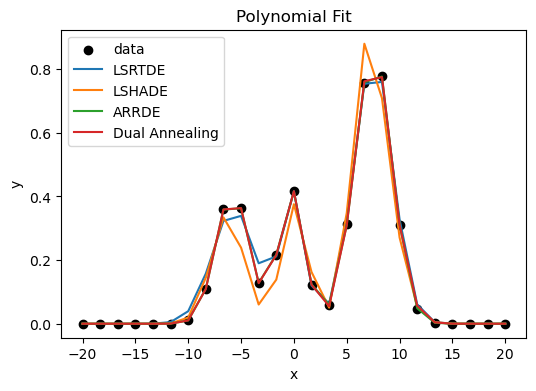

In [7]:
np.random.seed(5)  # For reproducibility

num_gauss = 5
true_centers = 10*(-1+2*np.random.random(num_gauss))
true_widths = np.random.rand(num_gauss) + 1.0  # Widths (variances)
true_coeffs = 2.0*np.random.rand(num_gauss)
dimension= num_gauss*3

# Define a Gaussian function
def gauss(x, center, width):
    """Compute a Gaussian RBF value given x, center, and width."""
    return (1.0/2.0*np.pi*width**2)*0.5  * np.exp(-((x - center) ** 2) / (2 * width ** 2))

# Define the function as a weighted sum of gaussians
def gmm(x, centers, widths, coeffs):
    result = np.zeros_like(x)
    coeffs= np.array(coeffs)
    norm_coeff = coeffs/np.sum(coeffs)
    for i in range(len(centers)):
        result += norm_coeff[i] * gauss(x, centers[i], widths[i])
    return result


# Generate dimension+10 data points
x_data = np.linspace(-20, 20,dimension+10)
y_data = gmm(x_data, true_centers, true_widths, true_coeffs)

# Step 2: Define the model for fitting
def gmm_model(x, params):
    """ model with combined parameters (centers, widths, and coefficients)."""
    num_gauss = len(params) // 3
    centers = params[:num_gauss]
    widths = params[num_gauss:2*num_gauss]
    coeffs = params[2*num_gauss:]
    return gmm(x, centers, widths, coeffs)

# Step 3: Define the objective function to minimize
def objective_function(params):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = gmm_model(x_data, params)
    return np.mean((y_data - y_pred) ** 2)


executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)
def objective_function_vect(params) : 
    ret = list(executor.map(objective_function, params))
    return ret


bounds= [(-10, 10)]*dimension
Nmaxeval=10000
algos = ["LSRTDE", "LSHADE", "ARRDE"]

plt.figure(figsize=(6,4))
plt.scatter(x_data, y_data, label="data", color="black")
for algo in algos : 
    res = mpy.Minimizer(objective_function_vect, bounds, x0=None, relTol=0.0, algo = algo, maxevals=Nmaxeval, callback=None, seed=None, options={"population_size": 0}).optimize()
    print(algo , " : ", res.fun)
    plt.plot(x_data, gmm_model(x_data, res.x ), label=algo)

dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval)
print("Dual Annealing : ", dual_ann.fun)
plt.plot(x_data, gmm_model(x_data, dual_ann.x ), label="Dual Annealing")
plt.legend()
plt.title('Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

executor.shutdown()


## More complex fitting problem: CT18 PDFs Fitting

Here, we provide a slightly more challenging curve fitting problem. The task is to reproduce the CT18 parton distribution functions (PDFs) \cite{Hou:2019efy}. The parameterization for valence up-quark ($u_v$), valence down-quark ($d_v$), gluon, anti-$u$ ($\bar{u}$), anti-$d$ ($\bar{d}$), and strange quark ($s$) PDFs at the initial scale is given by:
$$
    f_i(x) = a_0 x^{a_1-1} (1-x)^{a_2} P_i(y, a_3, a_4, \dots), \quad i \in \{u_v, d_v, g, \bar{u}, \bar{d}, s\}
$$
Here, $P_i(y)$ is a Bernstein polynomial of degree 4, 3, or 5, depending on the specific PDF. The variable $y$ is defined as $y = \sqrt{x}$ for $u_v$, $d_v$, and $g$, and as $y = (1 - (1 - \sqrt{x}))^{a_3}$ for the sea quarks. The objective function is:
$$
    L = \sum_i \frac{1}{N} \sum_{j=1}^N \left(y_j - f_i(x_j)\right)^2
$$
where $i \in \{u_v, d_v, g, \bar{u}, \bar{d}, s\}$. The dimensionality of this problem is $D = 47$.


In [8]:
class CT18PDFs : 
    def __init__(self) : 
        self.parameters = {
            "uv_0" : 3.385, "uv_1" : 0.763, "uv_2" : 3.036, "uv_3" : 1.502, "uv_4" : -0.147,"uv_5" : 1.671, "uv_6" : 0.,
            "dv_0" : 0.490, "dv_1" : 0.763, "dv_2" : 3.036, "dv_3" : 2.615, "dv_4" : 1.828,"dv_5" : 2.721, "dv_6" : 0., 
            "g_0" : 2.690, "g_1" : 0.531, "g_2" : 3.148, "g_3" : 3.032, "g_4" : -1.705, "g_5" : 1.354, 
            "ubar_0" : 0.414, "ubar_1" : -0.022, "ubar_2" : 7.737, "ubar_3" : 4.0, "ubar_4" : 0.618,"ubar_5" : 0.195, "ubar_6" : 0.871, "ubar_7" : 0.267,"ubar_8" : 0.733,
            "dbar_0" : 0.414, "dbar_1" : -0.022, "dbar_2" : 7.737, "dbar_3" : 4.0, "dbar_4" : 0.292,"dbar_5" : 0.647, "dbar_6" : 0.474, "dbar_7" : 0.741,"dbar_8" :1.0,
            "s_0" : 0.288, "s_1" : -0.022, "s_2" : 10.31, "s_3" : 4.0, "s_4" : 0.466,"s_5" : 0.466, "s_6" : 0.225, "s_7" : 0.225,"s_8" : 1.0,
        }
        self.xlist = np.linspace(1e-3, 0.8, 50)
        self.paramNames = list(self.parameters.keys())
        self.originalData = self.getData()

    def uv(self, x) : 
        a0 = self.parameters["uv_0"]
        a1 = self.parameters["uv_1"]
        a2 = self.parameters["uv_2"]
        a3 = self.parameters["uv_3"]
        a4 = self.parameters["uv_4"]
        a5 = self.parameters["uv_5"]
        a6 = self.parameters["uv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dv(self, x) : 
        a0 = self.parameters["dv_0"]
        a1 = self.parameters["dv_1"]
        a2 = self.parameters["dv_2"]
        a3 = self.parameters["dv_3"]
        a4 = self.parameters["dv_4"]
        a5 = self.parameters["dv_5"]
        a6 = self.parameters["dv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def g(self, x) : 
        a0 = self.parameters["g_0"]
        a1 = self.parameters["g_1"]
        a2 = self.parameters["g_2"]
        a3 = self.parameters["g_3"]
        a4 = self.parameters["g_4"]
        a5 = self.parameters["g_5"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**3 + np.sinh(a4) *3*y*(1-y)**2 + np.sinh(a5) *3*y**2*(1-y)  + y**3
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def ubar(self, x) : 
        a0 = self.parameters["ubar_0"]
        a1 = self.parameters["ubar_1"]
        a2 = self.parameters["ubar_2"]
        a3 = self.parameters["ubar_3"]
        a4 = self.parameters["ubar_4"]
        a5 = self.parameters["ubar_5"]
        a6 = self.parameters["ubar_6"]
        a7 = self.parameters["ubar_7"]
        a8 = self.parameters["ubar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dbar(self, x) : 
        a0 = self.parameters["dbar_0"]
        a1 = self.parameters["dbar_1"]
        a2 = self.parameters["dbar_2"]
        a3 = self.parameters["dbar_3"]
        a4 = self.parameters["dbar_4"]
        a5 = self.parameters["dbar_5"]
        a6 = self.parameters["dbar_6"]
        a7 = self.parameters["dbar_7"]
        a8 = self.parameters["dbar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def s(self, x) : 
        a0 = self.parameters["s_0"]
        a1 = self.parameters["s_1"]
        a2 = self.parameters["s_2"]
        a3 = self.parameters["s_3"]
        a4 = self.parameters["s_4"]
        a5 = self.parameters["s_5"]
        a6 = self.parameters["s_6"]
        a7 = self.parameters["s_7"]
        a8 = self.parameters["s_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def u(self, x) : return self.uv(x)+self.ubar(x)
    def d(self, x) : return self.dv(x)+self.dbar(x) 

    def setParameter(self, pars) : 
        assert(len(pars)==len(self.parameters)) 
        self.parameters= dict(zip(self.paramNames, pars))

    def getData(self) : 
        x= self.xlist
        return [ x*self.u(self.xlist), x*self.ubar(self.xlist), x*self.d(self.xlist), x*self.dbar(self.xlist), x*self.g(self.xlist), x*self.s(self.xlist)]
    
    def chi2(self, params) : 
        self.setParameter(params) 
        data = self.getData() 
        ret =0
        for do, d in zip(self.originalData, data) : 
            ret = ret + np.sum((do-d)**2)
        return ret 
    
    def chi2_vect(self, params, data=None) : 
        return [self.chi2(p) for p in params ]

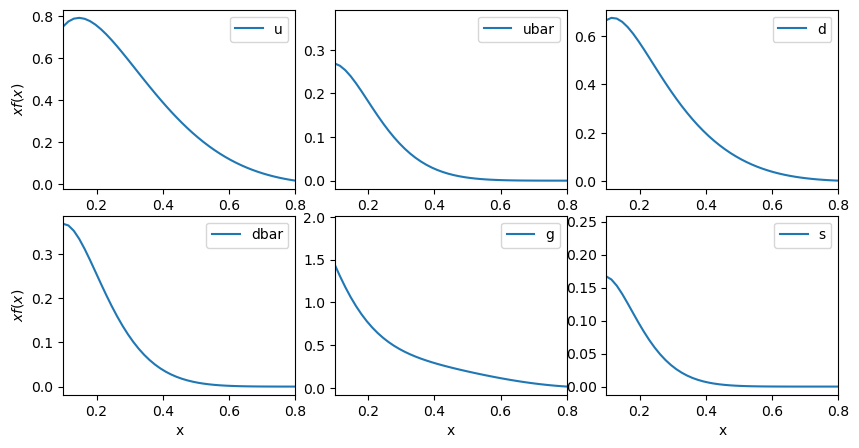

In [9]:
ct18 = CT18PDFs()
data = ct18.getData()

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# List of labels for each plot
labels = ["u", "ubar", "d", "dbar", "g", "s"]

# Plotting each function in its corresponding subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(ct18.xlist, data[i], label=labels[i])
    ax.set_xlim(0.1, 0.8)
    ax.set_xlabel("x")
    if (i%3 == 0):
        ax.set_ylabel(r"$xf(x)$")
    ax.legend()
plt.subplots_adjust(hspace=0.15, wspace=0.17)
plt.show()


Dimension :  47
	Obj  LSRTDE  :   1.3804128656013661
	Obj  ARRDE  :   0.44463194767378866
	Obj  LSHADE  :   11.720736329435775
	Obj  Scipy DA  :   1.6529183860856411


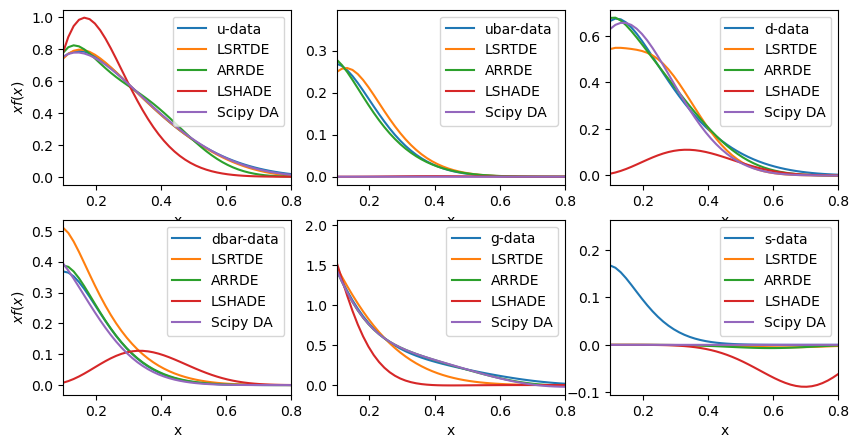

In [10]:
dimension = 47
print("Dimension : ", dimension)
bounds= [(-10, 10)]*dimension
Nmaxeval=50000

# Optimize the coefficientÄs using Nelder-Mead

#algos = ["LSHADE", "NLSHADE_RSP", "j2020", "jSO", "LSRTDE", "GWO_DE", "DE", "JADE", "ARRDE"]
algos = ["LSRTDE", "ARRDE", "LSHADE"]


results = {}
for algo in algos :
    res = mpy.Minimizer(ct18.chi2_vect,bounds, x0=None,algo=algo, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=i+2, options={"population_size": 0} ).optimize()
    print("\tObj ", algo, " :  ", res.fun)
    results[algo] = res

dual_ann = dual_annealing(ct18.chi2, bounds, maxfun=Nmaxeval)
print("\tObj ", "Scipy DA", " :  ", dual_ann.fun)
results["Scipy DA"] = dual_ann

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
labels = ["u-data", "ubar-data", "d-data", "dbar-data", "g-data", "s-data"]

# Plotting each function in its corresponding subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(ct18.xlist, data[i], label=labels[i])
    for algo in results : 
        ct18.setParameter(results[algo].x)
        theo = ct18.getData()
        ax.plot(ct18.xlist, theo[i], label=algo)
    ax.set_xlim(0.1, 0.8)
    ax.set_xlabel("x")
    if (i%3 == 0):
        ax.set_ylabel(r"$xf(x)$")
    ax.legend()
